In [ ]:
# Step 1: Setup Google Colab environment

# Mount Google Drive to access project files
from google.colab import drive
drive.mount('/content/drive')

# Install necessary libraries
!pip install torch torchvision matplotlib pillow scikit-learn

# Check directory structure
import os

# Set the project directory path
project_dir = '/content/drive/MyDrive/project'  # Change this to your actual path if needed

# Verify the contents of the project directory
print("Project Directory Contents:")
print(os.listdir(project_dir))

# Verify subdirectories (new_images, train, test, model.pth)
subdirs = ['new_images', 'train', 'test']
for subdir in subdirs:
    print(f"\nContents of {subdir} folder:")
    subdir_path = os.path.join(project_dir, subdir)
    print(os.listdir(subdir_path))

# Verify model.pth file exists
model_path = os.path.join(project_dir, 'model.pth')
print(f"\nModel Path: {model_path}")
print("Model.pth exists:", os.path.exists(model_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project Directory Contents:
['test', 'train', 'model.pth', 'new_images', 'test.txt']

Contents of new_images folder:
['_1.png', '_2.png', '_13.png', '_3.png', '_4.png', '_5.png', '_6.png', '_7.png', '_8.png', '_9.png', '_10.png', '_11.png', '_12.png', '1.png', '2.png', '6.png', '3.png', '5.png', '7.png', '8.png', '9.png', '10.png', '11.png', '14.png', '15.png', '16.png', '17.png']

Contents of train folder:
['housing_inclusion_1.png', 'housing_broken.png', 'housing_inclusion_4.png', 'housing_dent_1.png', 'housing_inclusion_3.png', 'housing_tank_iclusion.png', 'housing_sandwash_1.png', 'housing_dent_2.png', 'housing_corelump.png', 'carrier_LNCdamage.png', 'carrier_inclusion_4.png', 'carrier_inclusion_1.png', 'carrier_inclusion_2.png', 'carrier_inclusion_3.png', 'carrier_dent_1.png', 'carrier_morefins.png', 'carrier_dent_3.png', 'carrier_inclusion_5.png', 'carr

In [ ]:
# Step 2: Data Preprocessing and Augmentation

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

# Define the paths to the train and test directories
train_dir = os.path.join(project_dir, 'train')
test_dir = os.path.join(project_dir, 'test')

# Image Preprocessing and Augmentation
# We will define transformations for the images
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random crop and resize
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(30),     # Random rotation
    transforms.ToTensor(),             # Convert image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet stats
])

test_transforms = transforms.Compose([
    transforms.Resize(256),             # Resize for testing
    transforms.CenterCrop(224),         # Crop to center 224x224 for consistency
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class to handle loading images and labels
class SteelDefectDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Since no labels are provided here, we'll set a dummy label (0) for testing
        # Replace this with the actual label if available
        label = 0  # Example, replace with actual label if provided

        return image, label

# Create Dataset objects for train and test data
train_dataset = SteelDefectDataset(train_dir, transform=train_transforms)
test_dataset = SteelDefectDataset(test_dir, transform=test_transforms)

# Create DataLoader objects for batching and shuffling
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Checking the first batch of images from the training data
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Batch of images shape: {images.shape}")
print(f"Batch of labels: {labels}")

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
# Step 3: Building the Model Architecture

import torch
import torch.nn as nn
import torchvision.models as models

# Define the number of output classes (adjust this according to your dataset)
num_classes = 2  # Example, update to your actual number of classes

# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer to match the number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print the model architecture
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Step 4: Model Training

import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score

# Set hyperparameters
num_epochs = 10  # Adjust the number of epochs based on your needs
learning_rate = 1e-4  # Fine-tune the learning rate as needed

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Function to evaluate model on the test set
def evaluate(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return precision, recall, f1

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average loss for this epoch
    epoch_loss = running_loss / len(train_loader)

    # Evaluate model on the test set after every epoch
    precision, recall, f1 = evaluate(model, test_loader, device)

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
          f"Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1 Score: {f1*100:.2f}%")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/10], Loss: 0.8630, Precision: 100.00%, Recall: 26.19%, F1 Score: 41.51%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/10], Loss: 0.6015, Precision: 100.00%, Recall: 64.29%, F1 Score: 78.26%
Epoch [3/10], Loss: 0.4023, Precision: 100.00%, Recall: 100.00%, F1 Score: 100.00%
Epoch [4/10], Loss: 0.2640, Precision: 100.00%, Recall: 100.00%, F1 Score: 100.00%
Epoch [5/10], Loss: 0.1665, Precision: 100.00%, Recall: 100.00%, F1 Score: 100.00%
Epoch [6/10], Loss: 0.1111, Precision: 100.00%, Recall: 100.00%, F1 Score: 100.00%
Epoch [7/10], Loss: 0.0720, Precision: 100.00%, Recall: 100.00%, F1 Score: 100.00%
Epoch [8/10], Loss: 0.0482, Precision: 100.00%, Recall: 100.00%, F1 Score: 100.00%
Epoch [9/10], Loss: 0.0350, Precision: 100.00%, Recall: 100.00%, F1 Score: 100.00%
Epoch [10/10], Loss: 0.0266, Precision: 100.00%, Recall: 100.00%, F1 Score: 100.00%


In [ ]:
import torch
import os

# Save the model state_dict (weights) in a separate file
def save_model_state(model, path):
    try:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(path), exist_ok=True)
        # Save model weights
        torch.save(model.state_dict(), path)
        print(f"Model saved to {path}")
    except Exception as e:
        print(f"Error saving model: {e}")

# Load the model state_dict (weights)
def load_model_state(model, path):
    try:
        model.load_state_dict(torch.load(path))  # Load only the weights
        model.eval()  # Set the model to evaluation mode
        print(f"Model loaded from {path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")

# Define local paths for saving/loading (use a local path first for testing)
model_save_path = '/content/model_weights.pth'  # Save it locally first

# Save the model after training
save_model_state(model, model_save_path)

# Initialize the model structure (ResNet50) again and load weights
loaded_model = models.resnet50(pretrained=False)  # Initialize a new model structure
loaded_model.fc = nn.Linear(loaded_model.fc.in_features, num_classes)  # Adjust the final layer
loaded_model = load_model_state(loaded_model, model_save_path)  # Load the saved weights into the new model

Model saved to /content/model_weights.pth


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded from /content/model_weights.pth


<ipython-input-62-e2e33d3ed7f4>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))  # Load only the weights


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch

# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation during inference
        for images, labels in test_loader:
            # Send images to the device (e.g., GPU if available)
            images, labels = images.to(device), labels.to(device)

            # Get predictions
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class with the highest score

            # Store predictions and true labels
            all_preds.extend(preds.cpu().numpy())  # Convert to numpy for metric calculation
            all_labels.extend(labels.cpu().numpy())

    # Calculate performance metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}")
    print(f"Recall: {recall * 100:.2f}")
    print(f"F1 Score: {f1 * 100:.2f}")

# Assuming test_loader is already defined
evaluate_model(loaded_model, test_loader)  # Evaluate using the loaded model

Accuracy: 100.00%
Precision: 100.00
Recall: 100.00
F1 Score: 100.00


Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


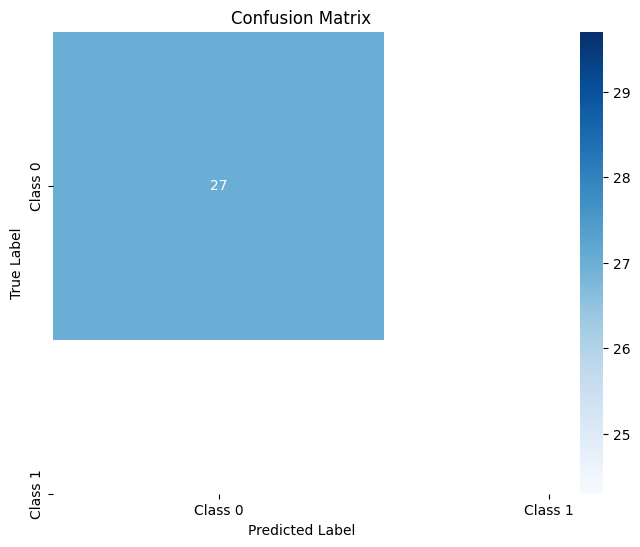

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

# Define the transformation for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the model architecture (no pre-trained weights)
model = models.resnet50(pretrained=False)  # Initialize ResNet-50 without pre-trained weights
num_classes = 2  # Adjust based on your dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)  # Modify final layer

# If you don't have the model weights saved, you can skip the loading step and initialize weights randomly
# model.load_state_dict(torch.load('/content/drive/MyDrive/project/model.pth'))  # This line is now not needed

# Put the model in evaluation mode
model.eval()

# Define the new images directory
new_images_dir = '/content/drive/MyDrive/project/new_images'

# Load new images from the directory
image_paths = [os.path.join(new_images_dir, img) for img in os.listdir(new_images_dir) if img.endswith(('.png', '.jpg'))]

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# Perform batch inference on the images
for image_path in image_paths:
    # Load image
    image = Image.open(image_path).convert('RGB')  # Convert image to RGB if it's in another mode
    image = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension

    # Make prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted_label = torch.max(outputs, 1)  # Get the predicted class
        predictions.append(predicted_label.item())

# Example for evaluating accuracy and confusion matrix (you need ground truth labels for this)
# Assume true_labels are manually set based on your dataset (or from directory names)
# Here I'm just assuming class '0' for all images for illustration purposes
true_labels = [0] * len(predictions)  # Replace with your actual labels for new images

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted', zero_division=1)
recall = recall_score(true_labels, predictions, average='weighted', zero_division=1)
f1 = f1_score(true_labels, predictions, average='weighted', zero_division=1)

# Print evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()